<a href="https://colab.research.google.com/github/Yanboding/MCIScheduling/blob/main/MCIDecision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gymnasium as gym
from gym import spaces
from gym.utils import seeding
import copy
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as RNG
from scipy.special import gamma
from pprint import pprint

In [3]:
def findNearestLowerBoundIndex(element, elements, key=lambda x: x):
    low = 0
    high = len(elements) - 1
    while low <= high:
        mid = (low + high)//2
        if key(elements[mid]) < key(element) or (mid+1 < len(elements) and key(elements[mid+1]) == key(element)):
            low = mid + 1
        elif key(elements[mid]) > key(element):
            high = mid - 1
        else:
            return mid
    return high


def getInsertionIndex(element, elements, key=lambda x: x):
    return findNearestLowerBoundIndex(element, elements, key) + 1

class EventNotice:

    def __init__(self, eventType, eventTime, eventObject):
        self.eventType = eventType
        self.eventTime = eventTime
        self.eventObject = eventObject


class EventCalendar:

    def __init__(self):
        self.clock = 0
        self.calendar = []

    def add(self, addedEvent):
        self.calendar.insert(findNearestLowerBoundIndex(addedEvent, self.calendar, key=lambda x: x.eventTime)+1,addedEvent)

    def remove(self):
        if len(self.calendar) > 0:
            nextEvent = self.calendar.pop(0)
            self.clock = nextEvent.eventTime
            return nextEvent

    def __len__(self):
        return len(self.calendar)

class Entity:

    def __init__(self, createTime, additionalInfo={}):
        self.createTime = createTime
        self.additionalInfo = additionalInfo
        self.leaveTime = 0
        self.isAbandon = False
        self.isUsedSurgery = False

    def to_dict(self):
        return {
            'id': self.additionalInfo['id'],
            'leftTime': self.leaveTime,
            'isAbandon': self.isAbandon,
            'isUsedSurgery': self.isUsedSurgery
        }


class Resource:
    def __init__(self, busy, numberOfUnits):
        self.busy = busy
        self.numberOfUnits = numberOfUnits

    def seize(self, units):
        originalBusyUnits = self.busy
        self.busy += units
        if self.numberOfUnits >= self.busy:
            return True
        else:
            self.busy = originalBusyUnits
            return False

    def free(self, units):
        if self.busy < units:
            return False
        else:
            self.busy -= units
            return True

class Node:

    def __init__(self, val):
        self.val = val
        self.prev = None
        self.next = None

    def isOrphan(self):
        return self.prev == None and self.next == None

class LinkedList:

    def __init__(self):
            self.head = Node(None)  # Dummy head
            self.tail = Node(None)  # Dummy tail
            self.head.next = self.tail
            self.tail.prev = self.head
            self.count = 0

    def is_empty(self):
        return self.head.next == self.tail

    def add_front(self, new_node):
        new_node.next = self.head.next
        new_node.prev = self.head
        self.head.next.prev = new_node
        self.head.next = new_node
        self.count += 1

    def add_back(self, new_node):
        new_node.next = self.tail
        new_node.prev = self.tail.prev
        self.tail.prev.next = new_node
        self.tail.prev = new_node
        self.count += 1

    def remove_front(self):
        if self.is_empty():
            return None
        front_node = self.head.next
        self.head.next = front_node.next
        front_node.next.prev = self.head
        front_node.next = front_node.prev = None
        self.count -= 1
        return front_node

    def remove_back(self):
        if self.is_empty():
            return None
        back_node = self.tail.prev
        self.tail.prev = back_node.prev
        back_node.prev.next = self.tail
        back_node.next = back_node.prev = None
        self.count -= 1
        return back_node

    def remove(self, node):
        node.prev.next = node.next
        node.next.prev = node.prev
        node.next = node.prev = None
        self.count -= 1

    def __len__(self):
        return self.count

    def display(self):
        current = self.head.next
        while current != self.tail:
            print(current.val, end=' ')
            current = current.next
        print()

class TimeStat:

    def __init__(self):
        self.times = []

    def record(self, time):
        if self.times == [] or self.times[-1] <= time:
            self.times.append(time)
        elif self.times[0] > time:
            self.times.insert(0, time)
        else:
            self.times.insert(getInsertionIndex(time, self.times), time)

class PatientStat:

    def __init__(self):
        self.patients = []

    def record(self, patient):
        i = getInsertionIndex(patient, self.patients, key=lambda p: (p.leaveTime, p.additionalInfo['id']))
        self.patients.insert(i, patient)

    def __str__(self):
        res = ''
        for patient in self.patients:
            res += str(patient.additionalInfo['id']) + ', ' + str(round(patient.leaveTime, 4)) + ', ' + str('abandon' if patient.isAbandon else 'finish') + '\n'
        return '[' + res[:-1] + ']'

    def __len__(self):
        return len(self.patients)

class MCI(gym.Env):

    def __init__(self, numberOfPatients):
        self.numberOfPatients = numberOfPatients
        self.calendar = EventCalendar()
        self.abandonTimeStat = TimeStat()
        self.patientLeftOrder = PatientStat()
        self.survivalRate = np.vectorize(self._survivalRateFun, otypes=[float])

    def _survivalRateFun(self, t):
        numberOfDeath = getInsertionIndex(t, self.abandonTimeStat.times)
        return (self.numberOfPatients - numberOfDeath) / self.numberOfPatients

    def recordDeath(self, patient):
        self.abandonTimeStat.record(patient.additionalInfo['abandonTime'])
        patient.leaveTime = patient.additionalInfo['abandonTime']
        patient.isAbandon = True
        self.patientLeftOrder.record(patient)

    def recordFinish(self, patient):
        if patient.isAbandon == False:
            patient.leaveTime = self.calendar.clock
            patient.isAbandon = False
            self.patientLeftOrder.record(patient)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class FCFSImagingMCIEnv(MCI):

    def __init__(self, patients, groupNumber, surgeryRoomNumber, ctRoomNumber):
        super().__init__(len(patients))
        self.patients = patients
        self.groupNumber = groupNumber
        self.surgeryRoomNumber = surgeryRoomNumber
        self.ctRoomNumber = ctRoomNumber
        # Track patients that are currently in surgery rooms
        self.busySurgeryRooms = set()
        # Track patients that are currently in CT rooms
        self.busyCTRooms = set()
        # Track queue for each group
        self.queues = [LinkedList() for _ in range(groupNumber)]
        # The patient is at which queue
        self.patientLocation = {}

    def _getState(self):
        state = [0, 0]*self.groupNumber
        numberOfSurgeries = len(self.busySurgeryRooms)
        numberOfWaitingPatients = 0
        for node in self.busySurgeryRooms:
            patientClass = node.val.additionalInfo['whichGroup']
            state[2*patientClass+1] += 1
        for i, queue in enumerate(self.queues):
            queueSize = len(queue)
            state[2*i] = queueSize
            numberOfWaitingPatients += queueSize
        # state, if the state is terminal, if the state need action
        return tuple(state), (numberOfSurgeries + numberOfWaitingPatients) == 0, (numberOfSurgeries < self.surgeryRoomNumber and numberOfWaitingPatients > 0)

    def tryEnterCTRooms(self):
        if len(self.busyCTRooms) < self.ctRoomNumber:
            node = self.queues[0].head.next
            while node in self.busyCTRooms:
                node = node.next
            while node != self.queues[0].tail and len(self.busyCTRooms) < self.ctRoomNumber:
                patient = node.val
                endOfImagingTime = self.calendar.clock + patient.additionalInfo['potentialImagingTime']
                if patient.additionalInfo['abandonTime'] > endOfImagingTime:
                    self.calendar.add(EventNotice('EndOfImaging', endOfImagingTime, node))
                self.busyCTRooms.add(node)
                node = node.next

    def abandon(self, node):
        patient = node.val
        # die in surgery
        if node in self.busySurgeryRooms:
            self.busySurgeryRooms.remove(node)
            self.recordDeath(patient)
        elif not node.isOrphan():
            # die while waiting
            self.patientLocation[node].remove(node)
            del self.patientLocation[node]
            if node in self.busyCTRooms:
                self.busyCTRooms.remove(node)

            self.recordDeath(patient)

    def endOfImaging(self, node):
        patient = node.val
        # check if the patient is still in ct room. It is possible that the patient has entered to surgery rooms
        if node in self.busyCTRooms:
            self.busyCTRooms.remove(node)
            self.patientLocation[node].remove(node)

            i = patient.additionalInfo['remainingLifeTimeClass']
            self.queues[i].add_back(node)
            self.patientLocation[node] = self.queues[i]

    def endOfSurgery(self, node):
        patient = node.val
        self.busySurgeryRooms.remove(node)
        self.recordFinish(patient)

    def enterSurgeryRooms(self, action):
        for i, number in enumerate(action):
            count = 0
            while count < number:
                if i == 0:
                    node = self.queues[i].remove_back()
                    if node in self.busyCTRooms:
                        self.busyCTRooms.remove(node)
                else:
                    node = self.queues[i].remove_front()
                # schedule EndOfSurgery event
                patient = node.val
                patient.additionalInfo['whichGroup'] = i
                patient.isUsedSurgery = True
                endOfSurgeryTime = self.calendar.clock + patient.additionalInfo['potentialSurgeryTime']
                if patient.additionalInfo['abandonTime'] > endOfSurgeryTime:
                    self.calendar.add(EventNotice('EndOfSurgery', endOfSurgeryTime, node))
                self.busySurgeryRooms.add(node)
                count += 1

    def reset(self):
        arrivalTime = self.calendar.clock
        for patient in self.patients:
            arrivalTime += patient[1]
            additionalInfo = {
                'id': patient[0],
                'abandonTime': patient[2],
                'potentialSurgeryTime': patient[3],
                'potentialImagingTime': patient[4],
                'remainingLifeTimeClass': patient[5]}
            node = Node(Entity(arrivalTime, additionalInfo))
            self.queues[0].add_back(node)
            self.patientLocation[node] = self.queues[0]
            self.calendar.add(EventNotice('Abandon', additionalInfo['abandonTime'], node))
        self.tryEnterCTRooms()
        state, _, _ = self._getState()
        return state

    def step(self, action):
        self.enterSurgeryRooms(action)
        # handle same timestamp event at the same time
        death = 0
        while len(self.calendar) > 0:
            buffer = defaultdict(list)
            nextEvent = self.calendar.remove()
            buffer[nextEvent.eventType].append(nextEvent)
            while len(self.calendar) > 0 and self.calendar.calendar[0].eventTime == self.calendar.clock:
                nextEvent = self.calendar.remove()
                buffer[nextEvent.eventType].append(nextEvent)
            for event in buffer['Abandon']:
                self.abandon(event.eventObject)
                if event.eventObject.val.isAbandon:
                    death += 1 # add if patient the patient not finish surgery
            for event in buffer['EndOfImaging']:
                self.endOfImaging(event.eventObject)
            for event in buffer['EndOfSurgery']:
                self.endOfSurgery(event.eventObject)
            self.tryEnterCTRooms()
            state, done, needAction = self._getState()
            if needAction:
                return state, death, done
        state, done, needAction = self._getState()
        return state, death, done


In [5]:
class MCIExpEnv(MCI):
    metadata = {}

    def __init__(self, simulator, numberOfPatients, surgeryRoomNumber, ctRoomNumber, surgeryRate, imagingRate, deathRatesByGroup, triageProbsByGroup):
        super().__init__(numberOfPatients)
        self.numberOfPatients = numberOfPatients
        self.surgeryRoomNumber = surgeryRoomNumber
        self.ctRoomNumber = ctRoomNumber
        self.surgeryRate = surgeryRate
        self.imagingRate = imagingRate
        self.deathRatesByGroup = deathRatesByGroup
        self.triageProbsByGroup = triageProbsByGroup
        self.groupNumber = len(deathRatesByGroup)
        self.s = (self.numberOfPatients,0)+(0,0)*(self.groupNumber-1)
        self.P = self._computeP() # {state:{action:[[prob, reward, done, nextState]]}}
        self.observation_space = spaces.MultiDiscrete([self.numberOfPatients, self.surgeryRoomNumber]*self.groupNumber)
        self.action_space = spaces.MultiDiscrete([self.surgeryRoomNumber]*self.groupNumber)
        self.simulator = simulator
        self.simulation = None

    def _calculateTransitionProb(self, state, action):
        nextState = list(state)
        totalRate = (min(self.ctRoomNumber, state[0] - action[0])) * self.imagingRate
        for j in range(self.groupNumber):
            nextState[2*j] -= action[j]
            nextState[2*j+1] += action[j]
            totalRate += (nextState[2*j] + nextState[2*j+1])*self.deathRatesByGroup[j]
            totalRate += nextState[2*j+1]*self.surgeryRate
        # imaging finished first
        if nextState[0] > 0:
            for k in range(1, self.groupNumber):
                classKFinishedImagingRate = self.triageProbsByGroup[k] * (min(self.ctRoomNumber, state[0] - action[0])) * self.imagingRate
                if classKFinishedImagingRate > 0:
                    tmpState = copy.copy(nextState)
                    tmpState[0] -= 1
                    tmpState[2*k] += 1
                    yield [classKFinishedImagingRate/totalRate, tuple(tmpState), 0, False]
        # someone die in queue first
        for l in range(self.groupNumber):
            tmpState = copy.copy(nextState)
            classLQueueDeathRate = (state[2*l] - action[l]) * self.deathRatesByGroup[l]
            if tmpState[2*l] > 0 and classLQueueDeathRate > 0:
                tmpState[2*l] -= 1
                yield [classLQueueDeathRate/totalRate, tuple(tmpState), 1, sum(tmpState) == 0]
        # someone left the OR rooms first
        for m in range(self.groupNumber):
            tmpState = copy.copy(nextState)
            classMLeavingRate = (state[2*m+1] + action[m])*(self.deathRatesByGroup[m] + self.surgeryRate)
            if tmpState[2*m+1] > 0 and classMLeavingRate > 0:
                tmpState[2*m+1] -= 1
                yield [classMLeavingRate/totalRate, tuple(tmpState), self.deathRatesByGroup[m]/(self.deathRatesByGroup[m] + self.surgeryRate), sum(tmpState) == 0]

    def _generateActions(self, state):
        remain = self.surgeryRoomNumber
        for i in range(self.groupNumber):
            remain -= state[2*i+1]
        queue = [(remain, ())]
        while len(queue) > 0:
            remain, curAction = queue.pop(0)
            for ui in range(min(remain, state[2*len(curAction)])+1):
                action = curAction + (ui,)
                if len(action) < self.groupNumber:
                    queue.append((remain-ui, action))
                else:
                    yield action

    def _computeP(self):
        p = {}
        p[self.s] = {}
        def dfs(state):
            for action in self._generateActions(state):
                p[state][action] = []
                for prob, nextState, reward, is_terminal in self._calculateTransitionProb(state, action):
                    p[state][action].append([prob, nextState, reward, is_terminal])
                    if nextState not in p:
                        p[nextState] = {}
                        dfs(nextState)
        dfs(self.s)
        return p

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        convertRateToMean = lambda rate: 1/rate if rate > 0 else float('inf')
        '''
        self.potentialSurgeryTimeGenerator = RNG.expon(scale=convertRateToMean(self.surgeryRate))
        self.potentialSurgeryTimeGenerator.random_state = np.random.RandomState(seed=1)

        self.potentialImagingTimeGenerator = RNG.expon(scale=convertRateToMean(self.imagingRate))
        self.potentialImagingTimeGenerator.random_state = np.random.RandomState(seed=2)
        '''

        surgeryTimeStd = 30
        averageSurgeryTime = convertRateToMean(self.surgeryRate)
        sigma = np.sqrt(np.log(1 + (surgeryTimeStd**2 / averageSurgeryTime**2)))
        self.potentialSurgeryTimeGenerator = RNG.lognorm(s=sigma,scale=np.exp(np.log(averageSurgeryTime) - sigma**2/2))
        #potentialServiceTimeGenerator = RNG.expon(scale=averageSurgeryTime)
        self.potentialSurgeryTimeGenerator.random_state = np.random.RandomState(seed=4)
        #print(potentialServiceTimeGenerator.stats(moments='mvsk'))
        ctTime = convertRateToMean(self.imagingRate)
        ctStd = 3
        self.potentialImagingTimeGenerator = RNG.norm(loc=ctTime, scale=ctStd)
        #imagingTimeGenerator = RNG.expon(scale=ctTime)
        self.potentialImagingTimeGenerator.random_state = np.random.RandomState(seed=5)

        self.remainingLifeTimeGenerators = []
        for i in range(self.groupNumber):
            remainingLifeTimeGenerator = RNG.expon(scale=convertRateToMean(self.deathRatesByGroup[i]))
            remainingLifeTimeGenerator.random_state = np.random.RandomState(seed=i+2)
            self.remainingLifeTimeGenerators.append(remainingLifeTimeGenerator)
        return [seed]

    def reset(self):
        # Reset the environment
        group = np.arange(self.groupNumber)

        # generate N patients
        #   for each patient, it has (id, interarrivalTime, remainingLifetime, potentialSurgeryTime, potentialImagingTime, remainingLifeTimeClass)
        patients = []
        for i in range(self.numberOfPatients):
            remainingLifeTimeClass = self.np_random.choice(group, 1, p=self.triageProbsByGroup)[0]
            interarrivalTime = 0
            remainingLifetime = self.remainingLifeTimeGenerators[remainingLifeTimeClass].rvs()
            potentialSurgeryTime = self.potentialSurgeryTimeGenerator.rvs()
            potentialImagingTime = self.potentialImagingTimeGenerator.rvs()
            patients.append([i, interarrivalTime, remainingLifetime, potentialSurgeryTime, potentialImagingTime, remainingLifeTimeClass])
        self.simulation = self.simulator(patients, self.groupNumber, self.surgeryRoomNumber, self.ctRoomNumber)
        return self.simulation.reset()

    def step(self, action):
        state, reward, done = self.simulation.step(action)
        return state, reward, done, {}

    def render(self):
        pass

In [6]:
def backwardInduction(env, discountFactor=1.0):
    V = defaultdict(lambda: 0)
    pi = defaultdict(lambda: None)
    def dfs(state):
        minExpectedDeath = float('inf')
        for action in env.P[state]:
            changeProb = 0
            q = 0
            for prob, nextState, reward, done in env.P[state][action]:
                if nextState != state:
                    changeProb += prob
                    if nextState in V or done:
                        nextStateVal = V[nextState]
                    else:
                        nextStateVal = dfs(nextState)
                    q += prob * (reward + discountFactor * nextStateVal)
            if changeProb > 0:
                q /= changeProb
                if q < minExpectedDeath:
                    minExpectedDeath = q
                    pi[state] = action
        V[state] = minExpectedDeath
        return V[state]
    dfs(env.s)
    return pi, V


In [7]:
import pandas as pd
def set_fontsize(ax, size):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

def performanceStatPlot(performanceStat):
    t = np.arange(performanceStat['NoImaging']['expectSurvivalRate'].shape[0])
    fig, ax = plt.subplots(1,1,figsize=(20, 10))
    ax.set_xlabel("time")
    ax.set_ylabel("Survival Rate")

    for key in performanceStat:
        ax.plot(t, performanceStat[key]['expectSurvivalRate'], '--', label=key)
        ax.fill_between(t, (performanceStat[key]['expectSurvivalRate'] - performanceStat[key]['survivalRateHalfWindow']), (performanceStat[key]['expectSurvivalRate'] + performanceStat[key]['survivalRateHalfWindow']), alpha=.1)
    set_fontsize(ax, 20)
    plt.legend(fontsize=13)
    plt.show()

def simulation(env, policy, simulationParameter):
    replicationNumber = simulationParameter['replicationNumber']
    t = simulationParameter['t']

    expectSurvivalRate = np.zeros_like(t)
    survivalRateSum = np.zeros_like(t)
    expectTotalDeath = 0
    expectNumberOfFailedSurgery = 0
    expectNumberOfDeathInWaiting = 0
    expectNumberOfSurgery = 0
    averageCost = 0
    for i in range(replicationNumber):
        #pprint(patients.tolist())
        #pprint([patients[:,2].mean(), patients[:,3].mean(), np.sqrt(patients[:,2].var()), np.sqrt(patients[:,3].var())])
        # simulate
        state = env.reset()
        action = policy[state]
        cost = 0
        state, reward, done, _ = env.step(action)
        cost += reward
        while not done:
            action = policy[state]
            state, reward, done, _ = env.step(action)
            cost += reward
        averageCost += (cost - averageCost)/(i+1)
        mciModel = env.simulation
        patientLeftOrder = pd.DataFrame.from_records([patient.to_dict() for patient in mciModel.patientLeftOrder.patients])
        expectTotalDeath += (patientLeftOrder[patientLeftOrder.isAbandon == True].shape[0] - expectTotalDeath)/(i+1)
        expectNumberOfFailedSurgery += (patientLeftOrder[(patientLeftOrder.isUsedSurgery == True) & (patientLeftOrder.isAbandon == True)].shape[0] - expectNumberOfFailedSurgery)/(i+1)
        expectNumberOfDeathInWaiting += (patientLeftOrder[(patientLeftOrder.isUsedSurgery == False) & (patientLeftOrder.isAbandon == True)].shape[0] - expectNumberOfDeathInWaiting)/(i+1)
        expectNumberOfSurgery += (patientLeftOrder[(patientLeftOrder.isUsedSurgery == True)].shape[0] - expectNumberOfSurgery)/(i+1)
        #print("number of Idle", mciModel.idleCount)
        #print("number of Death:", len(mciModel.abandonTimeStat.times))
        #print("death time:", mciModel.abandonTimeStat.times)
        #print("patients order:", len(mciModel.patientLeftOrder))

        survivalRateSamplePath = mciModel.survivalRate(t)
        survivalRateDiff = survivalRateSamplePath - expectSurvivalRate
        expectSurvivalRate += survivalRateDiff/(i+1)
        survivalRateSum += survivalRateDiff*(survivalRateSamplePath - expectSurvivalRate)
    survivalRateSampleVariance = np.zeros_like(t)
    survivalRateHalfWindow = np.zeros_like(t)
    if replicationNumber > 1:
        survivalRateSampleVariance = survivalRateSum/(replicationNumber-1)
        survivalRateStd = np.sqrt(survivalRateSampleVariance)
        survivalRateHalfWindow = 1.96 * survivalRateStd/np.sqrt(replicationNumber)

    return {
         'expectSurvivalRate': expectSurvivalRate,
         'survivalRateHalfWindow':survivalRateHalfWindow,
         'survivalRateSampleVariance': survivalRateSampleVariance,
         'sampleSize': replicationNumber,
         'expectTotalDeath': expectTotalDeath,
         'expectNumberOfFailedSurgery': expectNumberOfFailedSurgery,
         'expectNumberOfDeathInWaiting': expectNumberOfDeathInWaiting,
         'expectNumberOfSurgery': expectNumberOfSurgery,
         'averageCost': averageCost
         }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Expected Survival Rate: 0.32533999999999996+-0.002929605724451797
Theory Expected Survival Rate: 0.376573241205038
Number of Surgery: 21.06399999999997
Total Death: 33.73300000000002
Death Decompose: 4.797000000000017 28.93600000000003
Average Cost: 33.73300000000002
ctRoomNumber 2
Expected Survival Rate: 0.33726000000000017+-0.0031761183560521876
Theory Expected Survival Rate: 0.38413330432946957
Number of Surgery: 22.877999999999975
Total Death: 33.13699999999993
Death Decompose: 6.015 27.122000000000025
Average Cost: 33.13699999999993
Improve: 0.011920000000000208 +- 0.004320916281576443
ctRoomNumber 5
Expected Survival Rate: 0.33753999999999984+-0.003179903287579415
Theory Expected Survival Rate: 0.3841902109889871
Number of Surgery: 23.06900000000001
Total Death: 33.122999999999976
Death Decompose: 6.191999999999993 26.93099999999999
Average Cost: 33.122999999999976
Improve: 0.012199999999999878 +- 0.004323699182308954
ctRoomNumber 8
Expected Survival Rate: 0.3363600000000001+-0.0

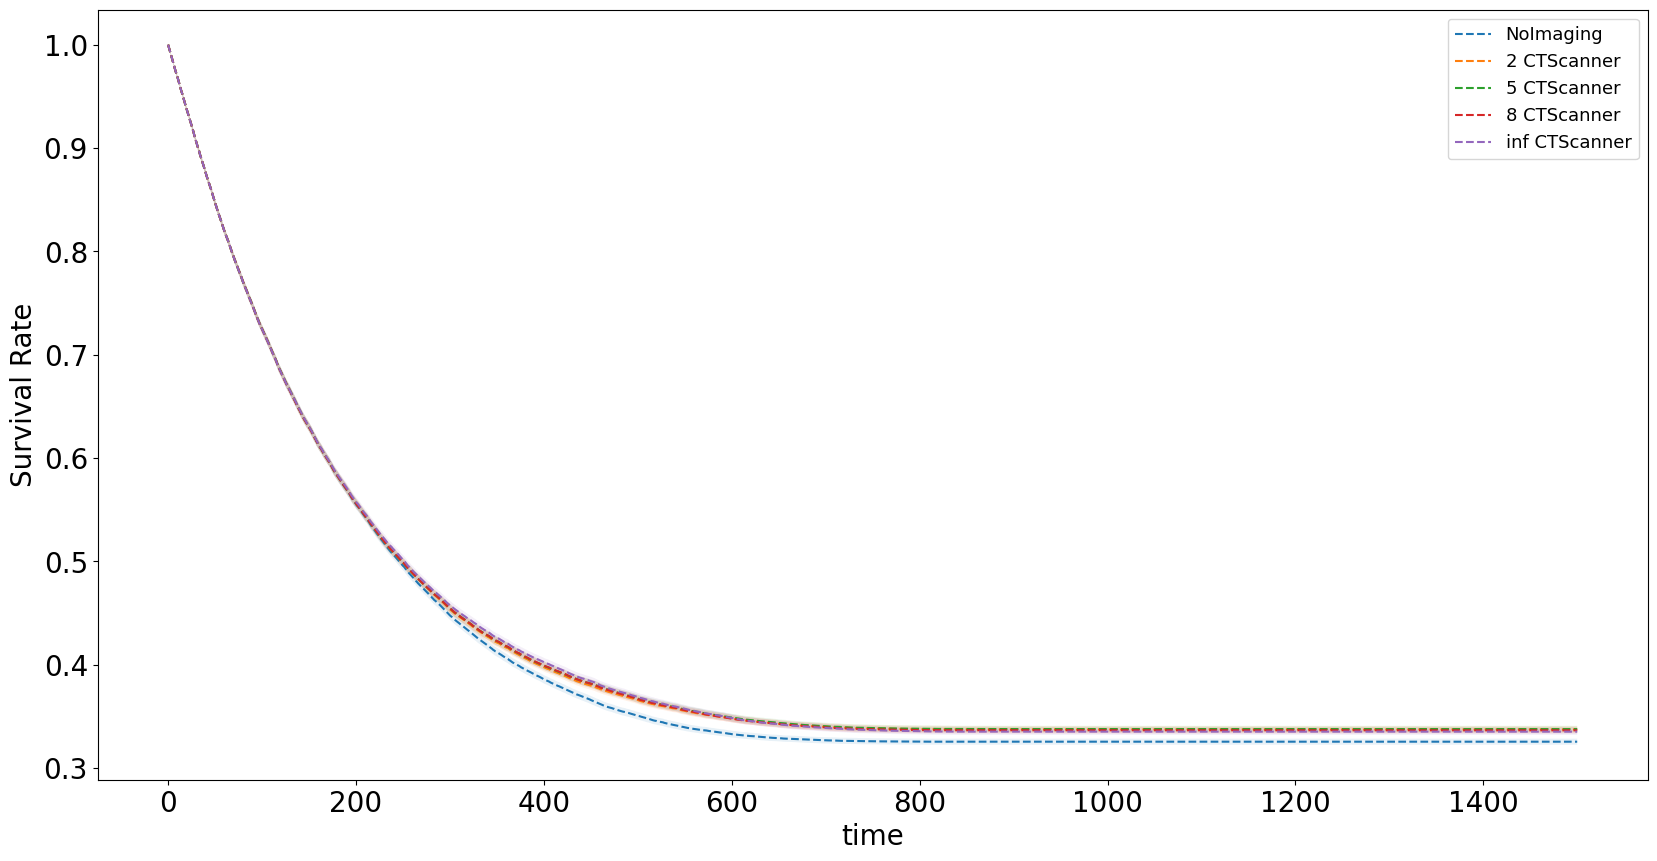

In [8]:
def experiment1():
    '''
    save the shortest remaining life time first patients
    '''
    parameters = {
        'simulator': FCFSImagingMCIEnv,
        'numberOfPatients': 50,
        'surgeryRoomNumber': 3,
        'ctRoomNumber': 0,
        'surgeryRate': 1/103,
        'imagingRate': 1/20,
        'deathRatesByGroup': [1/400, 1/200, 1/600],
        'triageProbsByGroup': [0, 1/2, 1/2]
    }
    simulationParameter = {'replicationNumber': 1000, 't': np.linspace(0, 1500, 1501)}
    mciExpEnv = MCIExpEnv(**parameters)
    mciExpEnv.seed(0)
    policy, V = backwardInduction(mciExpEnv)
    performanceStat = {}
    performanceStat['NoImaging'] = simulation(mciExpEnv, policy, simulationParameter)
    print("Expected Survival Rate:", str(performanceStat['NoImaging']['expectSurvivalRate'][-1]) + "+-" + str(performanceStat['NoImaging']['survivalRateHalfWindow'][-1]))
    print("Theory Expected Survival Rate:", (parameters['numberOfPatients'] - V[mciExpEnv.s])/parameters['numberOfPatients'])
    print('Number of Surgery:', performanceStat['NoImaging']['expectNumberOfSurgery'])
    print('Total Death:', performanceStat['NoImaging']['expectTotalDeath'])
    print('Death Decompose:', performanceStat['NoImaging']['expectNumberOfFailedSurgery'], performanceStat['NoImaging']['expectNumberOfDeathInWaiting'])
    print('Average Cost:', performanceStat['NoImaging']['averageCost'])

    ctRoomNumbers = [2, 5, 8, float('inf')]
    for ctRoomNumber in ctRoomNumbers:
        print('ctRoomNumber', ctRoomNumber)
        parameters['ctRoomNumber'] = ctRoomNumber
        mciExpEnv = MCIExpEnv(**parameters)
        mciExpEnv.seed(0)
        policy, V = backwardInduction(mciExpEnv)
        senarioName = str(ctRoomNumber)+' CTScanner'
        performanceStat[senarioName] = simulation(mciExpEnv, policy, simulationParameter)
        print("Expected Survival Rate:", str(performanceStat[senarioName]['expectSurvivalRate'][-1]) + "+-" + str(performanceStat[senarioName]['survivalRateHalfWindow'][-1]))
        print("Theory Expected Survival Rate:", (parameters['numberOfPatients'] - V[mciExpEnv.s])/parameters['numberOfPatients'])
        print('Number of Surgery:', performanceStat[senarioName]['expectNumberOfSurgery'])
        print('Total Death:', performanceStat[senarioName]['expectTotalDeath'])
        print('Death Decompose:', performanceStat[senarioName]['expectNumberOfFailedSurgery'], performanceStat[senarioName]['expectNumberOfDeathInWaiting'])
        print('Average Cost:', performanceStat[senarioName]['averageCost'])
        meanDiff = performanceStat[senarioName]['expectSurvivalRate'][-1] - performanceStat['NoImaging']['expectSurvivalRate'][-1]
        sampleVar1, sampleSize1 = performanceStat[senarioName]['survivalRateSampleVariance'][-1], performanceStat[senarioName]['sampleSize']
        sampleVar2, sampleSize2 = performanceStat['NoImaging']['survivalRateSampleVariance'][-1], performanceStat['NoImaging']['sampleSize']
        halfWindow = 1.96 * np.sqrt(sampleVar1/sampleSize1 + sampleVar2/sampleSize2)
        print('Improve:', meanDiff, "+-", halfWindow)
    return performanceStat
performanceStatPlot(experiment1())